<a href="https://colab.research.google.com/github/LucasDamascenoS/DeepLearning/blob/main/Covid19_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementation of the paper **CoroNet: A deep neural network for detection and diagnosis of COVID-19 from chest x-ray images**

The dataset used and CNN models can be found at: https://nextcloud.lasseufpa.org/s/JrxKko4NG5mFg2x

- If running on Google Colab, run the 2 cells below

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# unzip dataset and models
# specify the path on your Drive where the dataset.zip and models.zip is saved
!unzip /content/drive/MyDrive/path_to_dataset.zip
!unzip /content/drive/MyDrive/path_to_models.zip

In [1]:
# import libraries and packages
import cv2, os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.font_manager

from os import listdir
from numpy.random import seed
from skimage import transform

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

seed(8)
tf.random.set_seed(7)

2022-09-23 15:05:45.627018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-23 15:05:45.777871: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-23 15:05:46.276066: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/damasceno/anaconda3/envs/temp/lib/python3.9/site-packages/cv2/../../lib64:
2022-09-23 15:05:46.276120: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvin

**Crete Data Generators to preprocess and prepare training and validation**

In [2]:
# load the specific folder from the dataset and .hs file corresponding to the number of classes that you want to classify

# 0 - 2 classes: covid and normal
# 1 - 3 classes: covid, normal and pneumonia
# 2 - 4 classes: covid, normal, pneumonia bacterial and pneumonia viral
numberClasses = 0

# parameter to specify if running on Google Colab or Local
# 0 - running Local
# 1 - running on Google Colab
runColab = 0

if numberClasses == 0 and runColab == 0:
    DATASET_PATH = './dataset/two_classes'
    TRAIN_PATH = './dataset/two_classes/train'
    TEST_PATH = './dataset/two_classes/test'
    MODEL_PATH = './models/two_classes.h5'
    MODEL_NAME = 'two_classes.h5'
    CLASS_MODE = 'categorical'
    LOSS = 'categorical_crossentropy'
    ACTIVATION = 'softmax'
    LABELS = ["covid", "normal"]

elif numberClasses == 1 and runColab == 0:
    DATASET_PATH = './dataset/three_classes'
    TRAIN_PATH = './dataset/three_classes/train'
    TEST_PATH = './dataset/three_classes/test'
    MODEL_PATH = './models/three_classes.h5'
    MODEL_NAME = 'three_classes.h5'
    CLASS_MODE = 'categorical'
    LOSS = 'categorical_crossentropy'
    ACTIVATION = 'softmax'
    LABELS = ["covid", "normal", "pneumonia"]

elif numberClasses == 2 and runColab == 0:
    DATASET_PATH = './dataset/four_classes'
    TRAIN_PATH = './dataset/four_classes/train'
    TEST_PATH = './dataset/four_classes/test'
    MODEL_PATH = './models/four_classes.h5'
    MODEL_NAME = 'four_classes.h5'
    CLASS_MODE = 'categorical'
    LOSS = 'categorical_crossentropy'
    ACTIVATION = 'softmax'
    LABELS = ["covid", "normal", "pneumonia_bac", "pneumonia_vir"]

elif numberClasses == 0 and runColab == 1:
    DATASET_PATH = '/content/dataset/two_classes'
    TRAIN_PATH = '/content/dataset/two_classes/train'
    TEST_PATH = '/content/dataset/two_classes/test'
    MODEL_PATH = '/content/models/two_classes.h5'
    MODEL_NAME = 'two_classes.h5'
    CLASS_MODE = 'categorical'
    LOSS = 'categorical_crossentropy'
    ACTIVATION = 'softmax'
    LABELS = ["covid", "normal"]

elif numberClasses == 1 and runColab == 1:
    DATASET_PATH = '/content/dataset/three_classes'
    TRAIN_PATH = '/content/dataset/three_classes/train'
    TEST_PATH = '/content/dataset/three_classes/test'
    MODEL_PATH = '/content/models/three_classes.h5'
    MODEL_NAME = 'three_classes.h5'
    CLASS_MODE = 'categorical'
    LOSS = 'categorical_crossentropy'
    ACTIVATION = 'softmax'
    LABELS = ["covid", "normal", "pneumonia"]

elif numberClasses == 2 and runColab == 1:
    DATASET_PATH = '/content/dataset/four_classes'
    TRAIN_PATH = '/content/dataset/four_classes/train'
    TEST_PATH = '/content/dataset/four_classes/test'
    MODEL_PATH = '/content/models/four_classes.h5'
    MODEL_NAME = 'four_classes.h5'
    CLASS_MODE = 'categorical'
    LOSS = 'categorical_crossentropy'
    ACTIVATION = 'softmax'
    LABELS = ["covid", "normal", "pneumonia_bac", "pneumonia_vir"]

In [3]:
IMAGE_SIZE    = (150, 150)
NUM_CLASSES   = len(listdir(TRAIN_PATH))
BATCH_SIZE    = 10
NUM_EPOCHS    = 10
LEARNING_RATE =0.0001

# train datagen here is a preprocessor
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=50,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   zca_whitening = True,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode='constant')

train_batches = train_datagen.flow_from_directory(TRAIN_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "training",
                                                  seed=42,
                                                  class_mode=CLASS_MODE
                                                  )

valid_batches = train_datagen.flow_from_directory(TRAIN_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,
                                                  class_mode=CLASS_MODE
                                                  )

Found 640 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


/home/damasceno/anaconda3/envs/temp/lib/python3.9/site-packages/keras/preprocessing/image.py:1453: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn(


**CNN Model**

In [4]:
# this cell will create a CNN model
# if you already have a model, skip the next 4 cells and run the next one
conv_base = Xception(weights='imagenet',
                     include_top=False,
                     input_shape=(150, 150, 3)
                     )

conv_base.trainable = True

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(NUM_CLASSES, activation=ACTIVATION))

model.compile(loss=LOSS,
              optimizer=Adam(learning_rate=LEARNING_RATE),
              metrics=['acc']
              )

model.summary()

2022-09-23 15:06:00.885619: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 15:06:00.891657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 15:06:00.891839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 15:06:00.892201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dropout (Dropout)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 33,969,450
Trainable params: 33,914,922
Non-trainable params: 54,528
_________________________________________________________________


In [5]:
# training the model
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

result=model.fit(train_batches,
                 steps_per_epoch =STEP_SIZE_TRAIN,
                 validation_data = valid_batches,
                 validation_steps = STEP_SIZE_VALID,
                 epochs= NUM_EPOCHS,
                )

64
16
Epoch 1/10


/home/damasceno/anaconda3/envs/temp/lib/python3.9/site-packages/keras/preprocessing/image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/home/damasceno/anaconda3/envs/temp/lib/python3.9/site-packages/keras/preprocessing/image.py:1886: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
2022-09-23 15:06:10.224505: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-09-23 15:06:11.298865: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-09-23 15:06:11.298901: W tensorflow/co

64/64 [==============================] - 16s 156ms/step - loss: 0.7076 - acc: 0.6812 - val_loss: 0.7676 - val_acc: 0.6875
Epoch 2/10
64/64 [==============================] - 9s 146ms/step - loss: 0.4838 - acc: 0.7844 - val_loss: 0.4959 - val_acc: 0.7437
Epoch 3/10
64/64 [==============================] - 9s 146ms/step - loss: 0.4148 - acc: 0.8125 - val_loss: 0.3872 - val_acc: 0.8313
Epoch 4/10
64/64 [==============================] - 10s 148ms/step - loss: 0.3890 - acc: 0.8266 - val_loss: 0.5848 - val_acc: 0.7875
Epoch 5/10
64/64 [==============================] - 9s 147ms/step - loss: 0.3745 - acc: 0.8406 - val_loss: 0.3758 - val_acc: 0.8625
Epoch 6/10
64/64 [==============================] - 10s 150ms/step - loss: 0.3473 - acc: 0.8516 - val_loss: 0.4382 - val_acc: 0.7688
Epoch 7/10
64/64 [==============================] - 10s 149ms/step - loss: 0.3074 - acc: 0.8844 - val_loss: 0.4352 - val_acc: 0.7937
Epoch 8/10
64/64 [==============================] - 9s 146ms/step - loss: 0.3232 - 

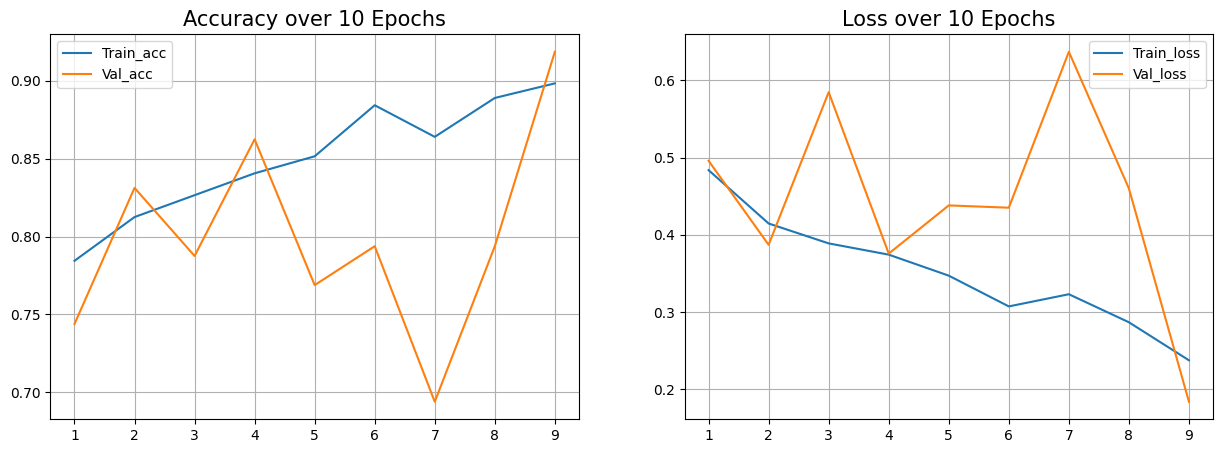

In [6]:
# plot the accuracy and loss graphs
def plot_acc_loss(result, epochs):
  acc = result.history['acc']
  loss = result.history['loss']
  val_acc = result.history['val_acc']
  val_loss = result.history['val_loss']
  plt.figure(figsize=(15, 5))
  plt.subplot(121)
  plt.plot(range(1,epochs), acc[1:], label='Train_acc')
  plt.plot(range(1,epochs), val_acc[1:], label='Val_acc')
  plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
  plt.legend()
  plt.grid(True)
  plt.subplot(122)
  plt.plot(range(1,epochs), loss[1:], label='Train_loss')
  plt.plot(range(1,epochs), val_loss[1:], label='Val_loss')
  plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
  plt.legend()
  plt.grid(True)
  plt.show()
    
plot_acc_loss(result, NUM_EPOCHS)

In [ ]:
# save the trained model
model.save(MODEL_NAME)

In [ ]:
# load saved model from .hs file
model = load_model(MODEL_PATH)
print(model.summary())

**Crete Data Generators to test and evaluate**

In [7]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  batch_size=1,
                                                  shuffle=False,
                                                  seed=42,
                                                  class_mode=CLASS_MODE
                                                  )

eval_generator.reset()

Found 100 images belonging to 2 classes.


In [8]:
# evalute the trained model on evaluate generator
eval_generator.reset()  

x = model.evaluate_generator(eval_generator,
                             steps = np.ceil(len(eval_generator)),
                             use_multiprocessing = False,
                             verbose = 1,
                             workers=1,
                             )

print('Test loss:' , x[0])
print('Test accuracy:',x[1])

/tmp/ipykernel_44538/3901453360.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  x = model.evaluate_generator(eval_generator,


100/100 [==============================] - 2s 14ms/step - loss: 0.1743 - acc: 0.9600
Test loss: 0.17434073984622955
Test accuracy: 0.9599999785423279


**Crete Data Generators on single folder/class from test and predict**

In [9]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

pred_generator = test_datagen.flow_from_directory(TEST_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  batch_size=1,
                                                  shuffle=False,
                                                  seed=42,
                                                  class_mode=CLASS_MODE
                                                  )

pred_generator.reset()   

count=[0]*NUM_CLASSES
files=pred_generator.filenames

for i in range(len(files)):
  x,y = pred_generator.next()
  img = x
  predict=model.predict(img)
  
  p=np.argmax(predict, axis=-1)
  print(str(p[0])+" "+files[pred_generator.batch_index-1])
  count[p[0]]+=1 

print(count)

Found 100 images belonging to 2 classes.
1/1 [==============================] - 1s 542ms/step
0 covid/covid_1077.jpeg
1/1 [==============================] - 0s 20ms/step
0 covid/covid_1108.jpeg
1/1 [==============================] - 0s 22ms/step
0 covid/covid_1119.jpeg
1/1 [==============================] - 0s 20ms/step
0 covid/covid_1146.jpeg
1/1 [==============================] - 0s 20ms/step
0 covid/covid_1211.jpeg
1/1 [==============================] - 0s 24ms/step
0 covid/covid_1226.jpeg
1/1 [==============================] - 0s 23ms/step
0 covid/covid_1294.jpeg
1/1 [==============================] - 0s 21ms/step
0 covid/covid_13.jpeg
1/1 [==============================] - 0s 19ms/step
0 covid/covid_1378.jpeg
1/1 [==============================] - 0s 20ms/step
0 covid/covid_1390.jpeg
1/1 [==============================] - 0s 19ms/step
0 covid/covid_1575.jpeg
1/1 [==============================] - 0s 20ms/step
0 covid/covid_1656.jpeg
1/1 [==============================] - 0s 21ms/s

/tmp/ipykernel_44538/415348183.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(eval_generator,steps = np.ceil(len(eval_generator)))


[[48  2]
 [ 2 48]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        50
           1       0.96      0.96      0.96        50

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



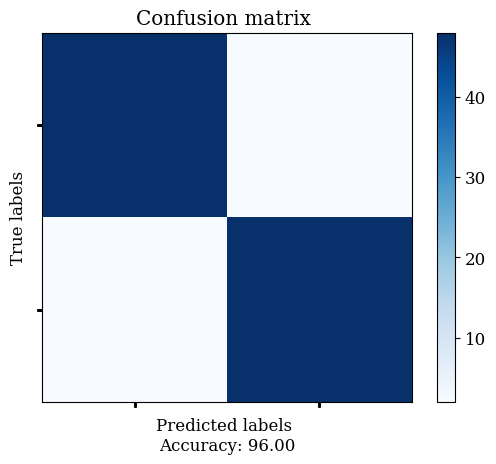

In [10]:
filenames = eval_generator.filenames
nb_samples = len(filenames)
eval_generator.reset()  
predict = model.predict_generator(eval_generator,steps = np.ceil(len(eval_generator)))
pp=predict
predict=np.argmax(predict, axis=-1)
classes= eval_generator.classes[eval_generator.index_array]
acc=sum(predict==classes)/len(predict)
names=LABELS

font = {
    'family': 'DeJavu Serif',
    'serif': 'Times New Roman',
    'size': 12
    }

plt.rc('font', **font)

cm = confusion_matrix(classes, predict)

print(cm)
print(classification_report(classes,predict))

plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted labels \nAccuracy: {:0.2f}'.format(acc*100))
plt.ylabel("True labels")
plt.xticks(classes, [])
plt.yticks(classes, [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

**Evaluate the model on a single image**

1/1 [==============================] - 0s 21ms/step
[[9.9991167e-01 8.8371409e-05]]


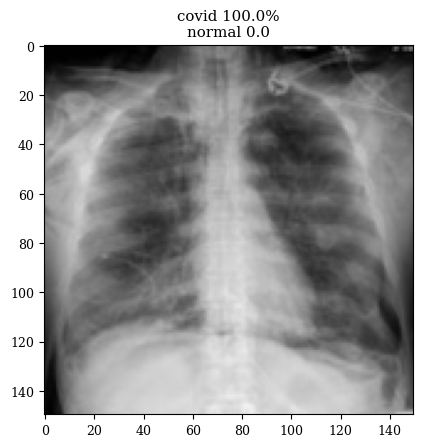

In [11]:
# use one of the following img_path to evaluate the model on a single image
# you can use any of the images on the dataset, these are only examples

# for 2 classes: covid and normal
img_path = TEST_PATH + '/covid/covid_13.jpeg'
#img_path = TEST_PATH + '/normal/normal_192.jpeg'

# for 3 classes: covid, normal and pneumonia
#img_path = TEST_PATH + '/covid/covid_13.jpeg'
#img_path = TEST_PATH + '/normal/normal_192.jpeg'
#img_path = TEST_PATH + '/pneumonia/pneumonia_196.jpeg'

# for 4 classes: covid, normal, pneumonia bacterial and pneumonia viral
#img_path = TEST_PATH + '/covid/covid_13.jpeg'
#img_path = TEST_PATH + '/normal/normal_192.jpeg'
#img_path = TEST_PATH + '/pneumonia_bacterial/pneumonia_bacterial_104.jpeg'
#img_path = TEST_PATH + '/pneumonia_viral/pneumonia_viral_79.jpeg'

img_r = cv2.imread(img_path)
img1 = np.array(img_r).astype('float32')/255
img2 = transform.resize(img1, (150, 150, 3))
img = np.expand_dims(img2, axis=0)

r=model.predict(img)

scores=r
print(scores)

font = {
    'family': 'DeJavu Serif',
    'serif': 'Times New Roman',
    'size': 9
    }

plt.rc('font', **font)

if numberClasses == 0:
    plt.title(names[0] +" "+ str(round(scores[0][0]*100,1))+"%"+"\n"+names[1] +" "+ str(round(scores[0][1]*100,1)))
elif numberClasses == 1:
    plt.title(names[0] +" "+ str(round(scores[0][0]*100,1))+"%"+"\n"+names[1] +" "+ str(round(scores[0][1]*100,1))+"%"+"\n"+names[2] +" "+ str(round(scores[0][2]*100,1)))
else:
    plt.title(names[0] +" "+ str(round(scores[0][0]*100,1))+"%"+"\n"+names[1] +" "+ str(round(scores[0][1]*100,1))+"%"+"\n"+names[2] +" "+ str(round(scores[0][2]*100,1))+"%"+"\n"+names[3] +" "+ str(round(scores[0][3]*100,1))+"%")
plt.imshow(img2)